## Construct 40% Unimpaired Flows (Feb-Jun) with FERC Flows (Jul-Jan) 
### Tuolumne River at Don Pedro Reservoir (CDEC ID TLG) (USGS ID: 11289650) 

In [7]:
import numpy as np 
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 600
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib.pyplot import cm
import dataretrieval.nwis as nwis
from scipy.signal import argrelextrema
from collections import defaultdict
from cdec_scraper import cdec_sensor_data
from datetime import date #for date.today() function

Import WYT data, create FERC flows data by WYT, combine FERC and FNF flows

In [23]:
# Define functions

# Import water year types (WYT) for SJB and SRB (generated using R code in separate file)
def download_WYT_data(WYT_input_file_from_R, WY_start):
    df = pd.read_csv(WYT_input_file_from_R, index_col=0, parse_dates=True)
    df_selected = pd.DataFrame(df['WY_type'][WY_start+'-01-01':'2023-01-01']).rename_axis('WY-date')
    df_selected['WY-date'] = pd.to_datetime(df_selected.index)
    df_selected['WY'] = df_selected['WY-date'].dt.strftime('%Y')
    df_selected = df_selected.set_index('WY').drop(columns=['WY-date']).rename(columns={'WY_type':'WYT'})
    return df_selected

def download_ferc_data(link):
    df = pd.read_csv(link, index_col=0)
    return df

def create_water_year_col(df):
    df['datetime'] = pd.to_datetime(df.index)
    df['month'] = df['datetime'].dt.strftime('%m')
    df['year'] = df['datetime'].dt.strftime('%Y')
    df['WY'] = np.where((df['month'] == '10') | (df['month'] == '11') | (df['month'] == '12'), df['year'].astype(int) + 1, df['year'].astype(int))
    df['WY'] = df['WY'].values.astype(str)
    columns_to_remove = ['datetime', 'month', 'year']
    df = df.drop(columns=columns_to_remove)
    return df

def assign_dates_as_index(df_original, df_new):
    first_known_date = df_original.index[0] # define the first known date as a string
    date_range = pd.date_range(start=first_known_date, periods=len(df_new), freq='D') # create a date range starting from the first known date
    df_new.index = date_range
    return df_new

def add_col_of_selected_rows(df, row_name, new_col_name):
    list_of_row_vals = []
    for index, row in df.iterrows():
        header = row[row_name] # 'WYT' column, one row at a time
        if header in df.columns: # if that value in the row of the 'WYT' column equals one of the column headers
            value = row[header] # let the value equal the row value of that column
            #if header not in selected_ferc_flow_by_WYT:
            #    selected_ferc_flow_by_WYT = []
        list_of_row_vals.append(value)
    df[new_col_name] = list_of_row_vals
    return df, list_of_row_vals

def replace_nan_with_avg(series):
    for i in range(len(series)):
        if pd.isna(series[i]):
            before = series[i - 1] if i > 0 and not pd.isna(series[i - 1]) else 0
            after = series[i + 1] if i < len(series) - 1 and not pd.isna(series[i + 1]) else 0
            series[i] = (before + after) / 2
    return series

def clean_uf_data(file):
    daily = pd.read_csv(file, index_col=0)
    daily = daily.mask(daily < 0, np.nan) # replace negative values with NaN
    daily = daily.apply(replace_nan_with_avg) # replace NaN values with average
    daily = daily.rolling(window=7).mean()
    return daily

def create_month_col(df):
    df['datetime'] = pd.to_datetime(df.index)
    df['month'] = df['datetime'].dt.strftime('%m')
    columns_to_remove = ['datetime']
    df = df.drop(columns=columns_to_remove)
    return df

def flow_selection_based_on_month(df):
    selected_flow = []
    ferc_month = ['07', '08', '09', '10', '11', '12', '01']
    #fnf_month = ['02', '03', '04', '05', '06']
    for index, row in df.iterrows():
        if row['month'] in ferc_month:
            selected_flow.append(row['ferc_cfs'])
        else:
            selected_flow.append(row['fnf_cfs']*0.4)
    df['flow_cfs'] = selected_flow
    selected_columns = ['flow_cfs']
    df = df[selected_columns]
    return df

def construct_uf_ferc_flows():
    
    # Import WYT for SVI and SJI
    WY_SVI = download_WYT_data('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\data_raw\\water_year_indices_SVI.csv', '1948')
    WY_SJI = download_WYT_data('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\data_raw\\water_year_indices_SJI.csv', '1923')
    
    # Import FERC flows by WYT
    ferc_1953_2024 = download_ferc_data('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\data_raw\\FERC_flows.csv')

    # Add column with WY to table
    ferc_1953_2024_WY = create_water_year_col(ferc_1953_2024)

    # Create column for WYT for each WY using merge function
    ferc_1953_2024_WYT = pd.merge(ferc_1953_2024_WY, WY_SJI, on='WY', how='left') # 'left' means keep all rows from df1 and add matching rows from df2 (NaN for non-matching rows)

    # Assign dates to the index column
    ferc_1953_2024_WYT = assign_dates_as_index(ferc_1953_2024_WY, ferc_1953_2024_WYT)

    # Assign one FERC flow that corresponds with actual WYT
    ferc_1953_2024_WYT, ferc_flow_list = add_col_of_selected_rows(ferc_1953_2024_WYT, 'WYT', 'ferc_cfs')

    # Drop columns from df
    columns_to_drop = ['C', 'D', 'BN', 'AN', 'W', 'WY', 'WYT']
    ferc_1953_2024_WYT = ferc_1953_2024_WYT.drop(columns=columns_to_drop)
    
    # Import UF data
    uf = clean_uf_data('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\data_raw\\fnf_tuol_cdec.csv')

    # Make FERC flows the same legnth as the FNF flows
    start_date_df = uf.index[0]
    end_date_df = uf.index[-1]
    ferc_1953_2024_WYT = ferc_1953_2024_WYT[start_date_df:end_date_df]

    # Add FNF as a column to FERC flows
    ferc_1953_2024_WYT['fnf_cfs'] = uf.loc[:,'TLG_FNF_CFS']

    # Add month column to FERC df
    ferc_1953_2024_WYT = create_month_col(ferc_1953_2024_WYT)

    # Create new df that selects FERC or FNF flows depending on month
    uf_with_ferc = flow_selection_based_on_month(ferc_1953_2024_WYT)
    uf_with_ferc.to_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\data_clean\\fnf_with_ferc.csv')
    
    return uf_with_ferc

    #ferc_1953_2024_WYT['1993-10-01':'1993-10-25']

In [24]:
uf_ferc_11289650 = construct_uf_ferc_flows()

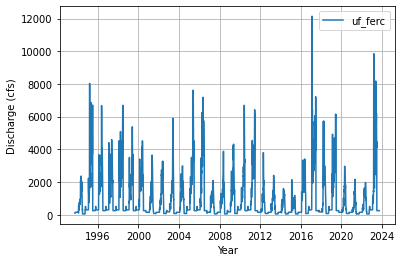

1993-10-01 00:00:00
2023-09-30 00:00:00


In [27]:
# plt.plot(uf_ferc_11289650, label = 'uf_ferc')
# #plt.plot(fnf, label = 'fnf')
# plt.xlabel('Year')
# plt.ylabel('Discharge (cfs)')
# plt.legend()
# plt.show()

# # Print start and end dates
# start_date_uf = uf_ferc_11289650.index.min()
# end_date_uf = uf_ferc_11289650.index.max()
# print(start_date_uf)
# print(end_date_uf)

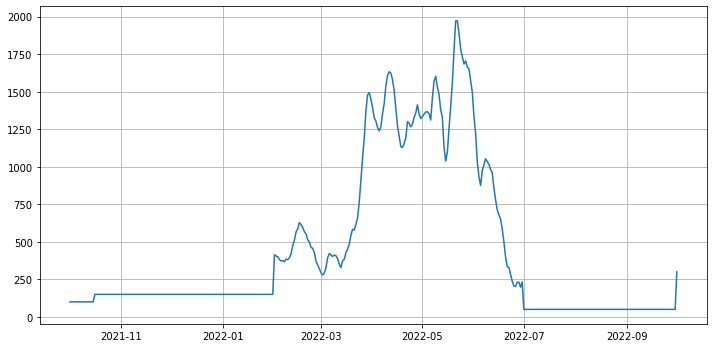

In [22]:
# def plot_single_year(df, year):
#     df = df.reset_index()
#     df['index']= pd.to_datetime(df['index'])
#     PLOT_START = str(year)+'-10-01'
#     next_year = year+1
#     PLOT_END = str(next_year)+'-10-01'
#     df_plot = df.loc[(df['index'] >= PLOT_START) & (df['index'] <= PLOT_END)]
#     #ax.plot(df_plot['flow_cfs'], label=flow_type)
#     return df_plot

# year = 2021
# plt.rcParams['axes.grid'] = True
# fig, ax = plt.subplots(1,1, figsize=(10,5))
# fig.tight_layout()

# df_plot = plot_single_year(uf_ferc_11289650, year)
# ax.plot(df_plot['index'], df_plot['flow_cfs'])
# plt.show()